### Análisis de Resultados

Finalizado el punto anterior, seleccionar uno de los modelos y realizar el siguiente análisis (se esperan respuestas cortas y concisas)

MODELO ELEGIDO: **Random Forest** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
import graphviz

In [2]:
data = pd.read_csv('../datasets/sneep-unificado-2002-2017-CURADO.csv')

/home/nahuel/anaconda3/envs/diploDatos/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (34,36,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
X = data[['delito1_id','provincia_id','genero_id','nacionalidad_id',
         'es_reincidente_id','anio_condenado','edad_al_ser_condenado',
          'nivel_instruccion_id','estado_civil_id']].astype(int)
y = data['duracion_condena_rango'].astype(int)

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.10, random_state = 0)

In [4]:
# Estos son los mejores parámetros encontrados con GridSearch en la notebook anterior
best_params = {'n_estimators':450, 
               'criterion':'entropy', 
               'max_depth':20, 
               'max_features':'auto', 
               'random_state':0}

model = RandomForestClassifier(n_estimators=best_params['n_estimators'], 
                               max_depth=best_params['max_depth'],
                               random_state=best_params['random_state'],
                               max_features=best_params['max_features'],
                               criterion=best_params['criterion']
                              )
model.fit(xTrain, yTrain)

yPred = model.predict(xTest)

1- Comparar los resultados sobre el set de entrenamiento y sobre el set de test. ¿Qué podemos decir respecto a sesgo y varianza en estos resultados?

Esta pregunta está relacionada con lo que se conoce como **the bias-variance tradeoff** (https://towardsdatascience.com/random-forests-and-the-bias-variance-tradeoff-3b77fee339b4). 

Se dice que un modelo está sesgado si sistemáticamente subestima o sobrestima la variable objetivo. Esto puede deberse a las suposiciones estadísticas hechas por el modelo elegido o a algún sesgo presente en los datos de entrenamiento.

La varianza captura la capacidad de generalizar del modelo, ya que es una medida de cuánto cambiaría nuestra predicción si la entrenamos en diferentes datos. Una varianza alta indicaría que es posible que el modelo esté overfitteando. 

Por lo general, modelos con un sesgo más bajo en la estimación de los parámetros, tienen una varianza más alta y viceversa. Lo que nos gustaría, idealmente, es un sesgo bajo y una varianza baja.

A continuación definimos una función que calcula el error cuadrático medio, la varianza y el sesgo.

In [11]:
def bias_variance(y_true_train, y_true_test, y_pred_train, y_pred_test):
    """
    Calcula el error cuadrático medio, la varianza y el sesgo
    """
    
    bias = np.mean((y_pred_train - y_true_train)**2)
    variance = np.mean((y_pred_test - y_true_test)**2)
   
    print("Bias: {bias}".format(bias=bias))
    print("Variance: {var}".format(var=variance))

In [13]:
print("-------------------------------------------------------------------------------------------------")
print("SET DE TEST:")
print("-------------------------------------------------------------------------------------------------")

print("-------------------------------------------------------------------------------------------------")
print(classification_report(yTest, yPred))
print('accuracy:', accuracy_score(yTest, yPred))

-------------------------------------------------------------------------------------------------
SET DE TEST:
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.44      0.13      0.20       288
           2       0.56      0.77      0.65      2012
           3       0.51      0.47      0.49      1658
           4       0.57      0.51      0.54      1143
           5       0.61      0.41      0.49       561
           6       0.69      0.43      0.53       285
           7       0.67      0.67      0.67       929

    accuracy                           0.57      6876
   macro avg       0.58      0.48      0.51      6876
weighted avg       0.57      0.57      0.56      6876

accuracy: 0.5706806282722513


In [16]:
print("-------------------------------------------------------------------------------------------------")
print("SET DE ENTRENAMIENTO:")
print("-------------------------------------------------------------------------------------------------")

yPred2 = model.predict(xTrain)

print("-------------------------------------------------------------------------------------------------")
print(classification_report(yTrain, yPred2))
print('accuracy:', accuracy_score(yTrain, yPred2))

-------------------------------------------------------------------------------------------------
SET DE ENTRENAMIENTO:
-------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.94      0.60      0.73      2509
           2       0.78      0.95      0.85     18430
           3       0.87      0.80      0.83     15216
           4       0.88      0.84      0.86      9735
           5       0.96      0.78      0.86      5176
           6       0.96      0.80      0.88      2601
           7       0.91      0.90      0.91      8212

    accuracy                           0.85     61879
   macro avg       0.90      0.81      0.85     61879
weighted avg       0.86      0.85      0.85     61879

accuracy: 0.8546194993454969


In [17]:
print("-------------------------------------------------------------------------------------------------")
print("SESGO Y VARIANZA:")
print("-------------------------------------------------------------------------------------------------")

bias_variance(yTrain, yTest, yPred2, yPred)

-------------------------------------------------------------------------------------------------
SESGO Y VARIANZA:
-------------------------------------------------------------------------------------------------
Bias: 0.6861132209634933
Variance: 2.1132926119837117


Obtuvimos una accuracy del 57% en el set de test, mientras que en el conjunto de entrenamiento la accuracy fué del 85%. También precision y recall dieron más alto en el conjunto de entrenamiento que en el de test (86% y 85% contra 57% y 57%). 

Los valores de accuracy para el conjunto de entrenamiento, si bien son más altos que los del conjunto de prueba, no son cercanos al 100%. Esto es un indicio de que el modelo no está sobreajustando los datos.

Por otro lado, el error cuadrático medio es mucho mayor en el set de prueba (2.11 contra 0.69), los sesgos (bias) dan cerca de 0 en ambos casos (-0.17 y -0.10), mientras que la varianza es casi la misma en ambos sets (3.02 y 3.06).

2- Imprimir la matriz de confusión de los resultados sobre el set de test. Desarrollar un análisis corto de lo que ven.

Definimos una función para graficar la **matriz de confusión**, esto nos ayudará a visualizar mejor los resultados.

In [18]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(np.round(cm, 3))

    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[  37  171   51   16    2    1   10]
 [  19 1552  294   80   24    8   35]
 [  13  605  775  139   38    9   79]
 [   6  210  199  585   45   15   83]
 [   1   87   91   85  229    7   61]
 [   1   28   34   46   13  122   41]
 [   7  110   76   73   25   14  624]]

Normalized confusion matrix
[[0.128 0.594 0.177 0.056 0.007 0.003 0.035]
 [0.009 0.771 0.146 0.04  0.012 0.004 0.017]
 [0.008 0.365 0.467 0.084 0.023 0.005 0.048]
 [0.005 0.184 0.174 0.512 0.039 0.013 0.073]
 [0.002 0.155 0.162 0.152 0.408 0.012 0.109]
 [0.004 0.098 0.119 0.161 0.046 0.428 0.144]
 [0.008 0.118 0.082 0.079 0.027 0.015 0.672]]



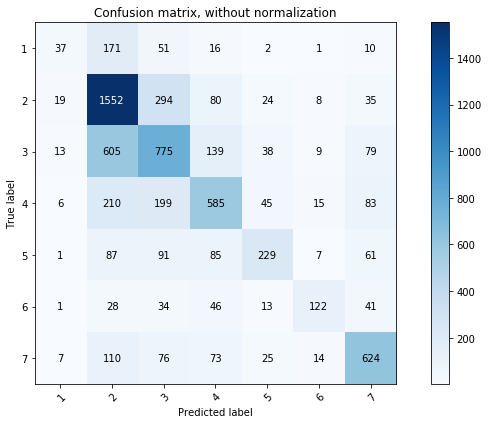

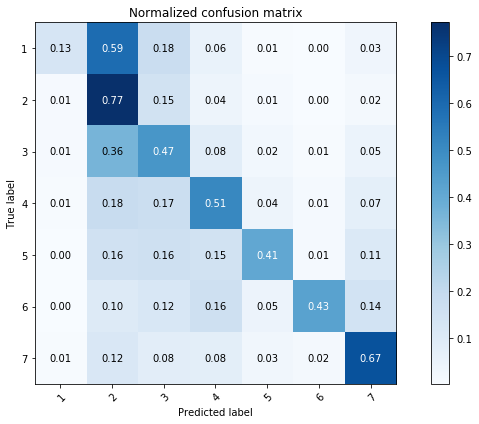

In [19]:
class_names = ['1', '2', '3', '4', '5', '6', '7']

# Plot non-normalized confusion matrix
plot_confusion_matrix(yTest, yPred, classes=class_names,
                      title='Confusion matrix, without normalization')
print()
# Plot normalized confusion matrix
plot_confusion_matrix(yTest, yPred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
print()
plt.tight_layout()  # Optional ... often improves the layout 

Se observa que el modelo entrenado clasifica bastante bien a las clases '2', '4' y '7' y bastante mal a la clase '1' (casi siempre sobrestima hacia la clase '2'). El resto de las clases las clasifica mediocremente (ni tan bien, ni tan mal).

3- Imprimir en una tabla (pueden crear un dataframe con los datos) la importancia relativa para el modelo de los distintos atributos (feature_importances_). Nuevamente, escribir un comentario respecto al resultado.

https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

Veamos la importancia de cada uno de los features de acuerdo con el attributo feature_importances_ de sklearn

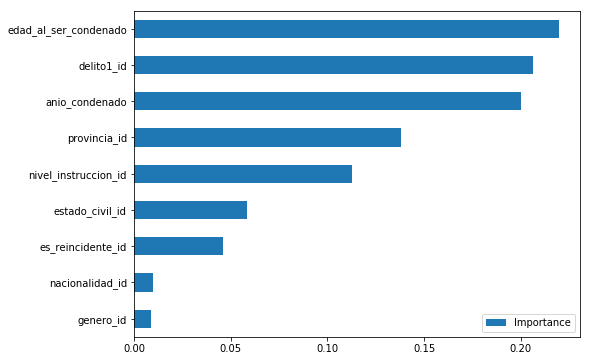

In [20]:
importances = pd.DataFrame(model.feature_importances_, columns=['Importance'], index=X.columns)
importances.sort_values(by='Importance').plot(kind='barh', figsize=(8, 6))

De acuerdo con este atributo, el feature con mayor importancia es "edad_al_ser_condenado", seguido por "delito1_id" y "anio_condenado". Si bien este resultado nos da algo de información, es importante notar que el método que utiliza sklearn para estimar la importancia de los features tiende a sobreestimar features continuos o categóricos de gran cardinalidad. 

Para compensar este bias, utilizamos la importancia por permutación.

In [21]:
from rfpimp import permutation_importances

## Necesitamos definir la metrica con este template para utilizar rfpimp
def accuracy(rf, X_train, y_train):
    return accuracy_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(model, xTrain, yTrain, accuracy)

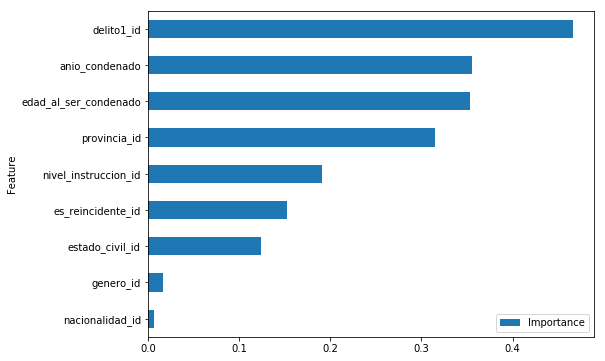

In [22]:
perm_imp_rfpimp.sort_values(by='Importance').plot(kind='barh', figsize=(8, 6))

De acuerdo con la importancia de permutación, la variable "delito1_id" es ahora la más importante, seguidas de "anio_condenado" y "edad_al_ser_condenado"

En los dos casos, podemos ver que el género y la nacionalidad son variables de poca importancia, por lo que constituyen opciones válidas para reducir el número de features del modelo.

### Mejora del Modelo

1- Luego de realizado el análisis, es momento de intentar mejorar nuestro modelo. En ésta oportunidad, ustedes deben elegir al menos dos cambios a realizar para intentar mejorar los resultados. Los cambios pueden ser (pero no están limitados a): 

- Agregar o quitar variables para entrenamiento (incluyendo otros delitos)
- Cambiar el encoding de las variables
- Recuperar registros que se filtraron al principio para tener más ejemplos
- Filtrar mayor cantidad de registros
- Generar una nueva variable (como se hizo con edad_al_ser_condenado)


**Reducción de features**

Evaluamos el efecto de remover los features de menor importancia ('genero_id' y 'nacionalidad_id')

In [23]:
cols_to_drop = [
    ['genero_id'],
    ['nacionalidad_id'],
    ['genero_id', 'nacionalidad_id']
]

print('Modelo original')
print('accuracy train:', accuracy_score(yTrain, yPred2))
print('accuracy test :', accuracy_score(yTest, yPred))
print('-----------------------------', end='\n\n')

for cols in cols_to_drop:
    reduced_xTrain = xTrain.drop(cols, axis=1)
    reduced_xTest = xTest.drop(cols, axis=1)
    reduced_yTrain = yTrain
    reduced_yTest = yTest

    model = RandomForestClassifier(n_estimators=best_params['n_estimators'], 
                               max_depth=best_params['max_depth'],
                               random_state=best_params['random_state'],
                               max_features=best_params['max_features'],
                               criterion=best_params['criterion']
    )
    model.fit(reduced_xTrain, yTrain)

    reduced_yPred = model.predict(reduced_xTest)
    reduced_yPred2 = model.predict(reduced_xTrain)
    
    print(cols)
    print('accuracy train:', accuracy_score(yTrain, reduced_yPred2))
    print('accuracy test :', accuracy_score(yTest, reduced_yPred))
    print('-----------------------------', end='\n\n')

Modelo original
accuracy train: 0.8546194993454969
accuracy test : 0.5706806282722513
-----------------------------

['genero_id']
accuracy train: 0.8501753422001002
accuracy test : 0.5644269924374636
-----------------------------

['nacionalidad_id']
accuracy train: 0.8487370513421355
accuracy test : 0.5700988947062245
-----------------------------

['genero_id', 'nacionalidad_id']
accuracy train: 0.8615039027780023
accuracy test : 0.5725712623618383
-----------------------------



Vemos que la predicción del modelo varía muy poco independientemente de si se incluyen o no cualquiera de los dos features. En particular, al sacar ambos, la predicción prácticamente no varía. 

**Incorporación de features**

Construimos dos nuevos features y evaluamos su impacto en la predicción.

El primer feature, "baires", indica si el establecimiento está en la provincia de buenos aires. La motivación de elegir este feature es que la gran mayoría de los registros corresponde a establecimientos en esa provincia.

El segundo feature, "federal", indica si el establecimiento en cuestión pertenece o no al sistema penitenciario federal. La importancia de esta variable radica en que los establecimientos federales alojan internos que han cometido distintos delitos que los internos de los establecimientos provinciales. Por ejemplo, la mayoría de las penas asociadas a delitos de narcotráfico se cumplen en estos establecimientos.

In [24]:
data['baires'] = (data.provincia_id == 1).astype('int')
data['federal'] = data.establecimiento_descripcion.str.contains('SPF').values.astype('int')

_X = data[['delito1_id','federal', 'provincia_id', 'baires', 'ultima_situacion_laboral_id', 'genero_id','nacionalidad_id',
         'es_reincidente_id','anio_condenado','edad_al_ser_condenado',
          'nivel_instruccion_id','estado_civil_id']].astype(int)

_y = data['duracion_condena_rango'].astype(int)

_xTrain, _xTest, _yTrain, _yTest = train_test_split(_X, _y, test_size = 0.10, random_state = 0)

In [106]:
cols_to_drop = [ 
    [],
    ['federal'],
    ['provincia_id'],
    ['baires'],
    ['federal', 'provincia_id'],
    ['federal', 'baires'],
    ['provincia_id', 'baires'],
    ['federal', 'provincia_id', 'baires'],
]

print('Modelo original')
print('accuracy train:', accuracy_score(yTrain, yPred2))
print('accuracy test :', accuracy_score(yTest, yPred))
print('-----------------------------', end='\n\n')

for cols in cols_to_drop:
    reduced_xTrain = _xTrain.drop(cols, axis=1)
    reduced_xTest = _xTest.drop(cols, axis=1)
    reduced_yTrain = _yTrain
    reduced_yTest = _yTest

    model = RandomForestClassifier(n_estimators=best_params['n_estimators'], 
                               max_depth=best_params['max_depth'],
                               random_state=best_params['random_state'],
                               max_features=best_params['max_features'],
                               criterion=best_params['criterion']
    )
    model.fit(reduced_xTrain, yTrain)

    reduced_yPred = model.predict(reduced_xTest)
    reduced_yPred2 = model.predict(reduced_xTrain)
    
    print(cols)
    print('accuracy train:', accuracy_score(yTrain, reduced_yPred2))
    print('accuracy test :', accuracy_score(yTest, reduced_yPred))
    print('-----------------------------', end='\n\n')

Modelo original
accuracy train: 0.8615039027780023
accuracy test : 0.5706806282722513
-----------------------------

[]
accuracy train: 0.8365519804780297
accuracy test : 0.566608493310064
-----------------------------

['federal']
accuracy train: 0.843614150196351
accuracy test : 0.5684991273996509
-----------------------------

['provincia_id']
accuracy train: 0.8003038187430308
accuracy test : 0.5314136125654451
-----------------------------

['baires']
accuracy train: 0.8479613439131207
accuracy test : 0.5719895287958116
-----------------------------

['federal', 'provincia_id']
accuracy train: 0.8028087073158907
accuracy test : 0.5274869109947644
-----------------------------

['federal', 'baires']
accuracy train: 0.8546194993454969
accuracy test : 0.5706806282722513
-----------------------------

['provincia_id', 'baires']
accuracy train: 0.7866966175923981
accuracy test : 0.5277777777777778
-----------------------------

['federal', 'provincia_id', 'baires']
accuracy train: 0.77

Vemos que incorporar los nuevos features no mejora, en general, la predicción. Por otra parte, si reemplazamos la variable "provincia_id" por "baires" o por "federal", la predicción empeora. Esto quiere decir que la información de a qué provincia pertenece cada establecimiento es importante. 

In [25]:
print(best_params)

{'n_estimators': 450, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'random_state': 0}


In [26]:
X = data[['delito1_id','provincia_id','genero_id','nacionalidad_id',
         'es_reincidente_id','anio_condenado','edad_al_ser_condenado',
          'nivel_instruccion_id','estado_civil_id']].astype(int)
y = data['duracion_condena_rango'].astype(int)

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.10, random_state = 0)

cols = ['genero_id', 'nacionalidad_id']

reduced_xTrain = xTrain.drop(cols, axis=1)
reduced_xTest = xTest.drop(cols, axis=1)
reduced_yTrain = yTrain
reduced_yTest = yTest

model = RandomForestClassifier(n_estimators=best_params['n_estimators'], 
                           max_depth=best_params['max_depth'],
                           random_state=best_params['random_state'],
                           max_features=best_params['max_features'],
                           criterion=best_params['criterion']
)
model.fit(reduced_xTrain, yTrain)

reduced_yPred = model.predict(reduced_xTest)
reduced_yPred2 = model.predict(reduced_xTrain)

print(cols)
print('accuracy train:', accuracy_score(yTrain, reduced_yPred2))
print('accuracy test :', accuracy_score(yTest, reduced_yPred))
print('-----------------------------', end='\n\n')

['genero_id', 'nacionalidad_id']
accuracy train: 0.8615039027780023
accuracy test : 0.5725712623618383
-----------------------------



In [33]:
rand_para = {'n_estimators':[10, 30, 100, 300],
             #'criterion':['gini', 'entropy'],
             #'max_depth':[None, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, 70, 90, 100, 110, 120, 130, 150, 200, 250],
             #'max_features':['sqrt', 'log2', None],
             'random_state': [0],
            }

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
def grid(model, params, n_jobs=None, verbose=0):

    clf = GridSearchCV(model, params, cv=StratifiedKFold(n_splits=3).split(xTrain, yTrain), 
                       n_jobs=n_jobs, verbose=verbose)
    clf.fit(xTrain, yTrain)

    print("Mejor conjunto de parámetros:")
    print(clf.best_params_, end="\n\n")

    print("Puntajes de la grilla:", end="\n\n")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("Exactitud: %0.4f (+/-%0.04f) para los parámetros %r" % (np.sqrt(mean), np.sqrt(std), params))
        
    return clf

n_jobs = 4
model = grid(model=RandomForestClassifier(), params=rand_para, n_jobs=n_jobs, verbose=10)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done   7 out of  12 | elapsed:    8.7s remaining:    6.2s
[Parallel(n_jobs=4)]: Done   9 out of  12 | elapsed:   11.8s remaining:    3.9s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:   29.5s finished


Mejor conjunto de parámetros:
{'n_estimators': 300, 'random_state': 0}

Puntajes de la grilla:

Exactitud: 0.7217 (+/-0.0644) para los parámetros {'n_estimators': 10, 'random_state': 0}
Exactitud: 0.7289 (+/-0.0590) para los parámetros {'n_estimators': 30, 'random_state': 0}
Exactitud: 0.7318 (+/-0.0655) para los parámetros {'n_estimators': 100, 'random_state': 0}
Exactitud: 0.7336 (+/-0.0626) para los parámetros {'n_estimators': 300, 'random_state': 0}


### Conclusiones

Escribir una conclusión breve respecto al trabajo. Particularmente sus ideas respecto a la pregunta inicial:
¿Es posible predecir la duración de la condena que recibirá una persona en base a datos como los que se encuentran presentes en este dataset?

Mencionar: 
- La calidad de los resultados obtenidos.
- Causas posibles de problemas que hayan detectado.
- Posibles soluciones